# Import packages

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler

# Load data

In [57]:
pd.read_csv('pred_solution11.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29903 entries, 0 to 29902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subscribed  29903 non-null  float64
 1   occasional  29903 non-null  float64
dtypes: float64(2)
memory usage: 467.4 KB


In [66]:
row_len

29903

In [71]:
test_df = pd.read_excel('Test.xlsx')

df_s = pd.DataFrame()
df_o = pd.DataFrame()

test_df_s = pd.DataFrame()
test_df_o = pd.DataFrame()

for i in [2, 11]:

    temp_df = pd.read_csv(f'pred_solution{i}.csv')
    if i == 2:
        row_len = temp_df.shape[0]

    if temp_df.shape[0] < row_len: 
        row_len = temp_df.shape[0]
        df_s = df_s.iloc[df_s.shape[0]-row_len:].reset_index(drop=True)
        df_o = df_o.iloc[df_o.shape[0]-row_len:].reset_index(drop=True)

    df_s = pd.concat([df_s, temp_df['subscribed'].apply(lambda x: 0 if x < 0 else x)], axis=1)
    df_s.rename(columns={'subscribed': f's{i}'}, inplace=True)

    df_o = pd.concat([df_o, temp_df['occasional'].apply(lambda x: 0 if x < 0 else x)], axis=1)
    df_o.rename(columns={'occasional': f's{i}'}, inplace=True)

    temp_test_df = pd.read_csv(f'solution{i}_submit.csv')
    temp_test_df['User_type'] = test_df['User_type'].values

    test_df_s = pd.concat(
        [
            test_df_s, 
            temp_test_df[temp_test_df['User_type']=='subscribed']['Rental_Bicycles_Count'].\
                apply(lambda x: 0 if x < 0 else x)], axis=1)
    test_df_s.rename(columns={'Rental_Bicycles_Count': f's{i}'}, inplace=True)

    test_df_o = pd.concat(
        [
            test_df_o, 
            temp_test_df[temp_test_df['User_type']=='occasional']['Rental_Bicycles_Count'].\
                apply(lambda x: 0 if x < 0 else x)], axis=1)
    test_df_o.rename(columns={'Rental_Bicycles_Count': f's{i}'}, inplace=True)

In [72]:
df_s.head()

,s2,s11
0,6.868760,9.533608
1,7.261021,11.366840
2,0.000000,1.663711
3,0.000000,0.000000
4,6.321993,7.532129


In [73]:
df_o.head()

,s2,s11
0,9.050616,11.085679
1,5.924590,1.579756
2,2.912014,0.133297
3,1.977700,0.000000
4,5.994013,2.362867


In [74]:
test_df_s.head()

,s2,s11
1,361.923676,240.850494
3,342.556396,145.234634
5,227.015472,65.673340
7,158.736374,31.720930
9,102.697601,38.757355


In [75]:
test_df_o.head()

,s2,s11
0,192.490341,183.972031
2,126.959404,135.288040
4,84.722290,89.195694
6,41.215275,49.360397
8,18.443666,33.111454


In [76]:
train_df = pd.read_excel('Train.xlsx')

train_full_dates = pd.date_range(start='2013-01-01', end='2016-06-01', freq='60min')[:-1]

missing_dates_dict = {}
for user_type in train_df['User_type'].unique():
    train_date = train_df[train_df['User_type']==user_type]['Datetime'].tolist()
    missing_dates = [i for i in train_full_dates if i not in train_date]
    missing_dates_dict[user_type] = missing_dates
    print(f"{user_type}: {len(missing_dates)} missing dates")

occasional: 97 missing dates
subscribed: 50 missing dates


In [77]:
train_df.drop(columns='Unnamed: 0', inplace=True)

train_df_s = train_df[train_df['User_type']=='subscribed'].reset_index(drop=True)
train_df_s.sort_values('Datetime', ascending=True, inplace=True)
train_df_o = train_df[train_df['User_type']=='occasional'].reset_index(drop=True)
train_df_o.sort_values('Datetime', ascending=True, inplace=True)

print(train_df_s.shape, train_df_o.shape)

(29878, 7) (29831, 7)


In [78]:
valid_df_s = train_df_s.iloc[-720:]
train_df_s = train_df_s.iloc[:-720]
print(valid_df_s.shape, train_df_s.shape)

valid_df_o = train_df_o.iloc[-720:]
train_df_o = train_df_o.iloc[:-720]
print(valid_df_o.shape, train_df_o.shape)

(720, 7) (29158, 7)
(720, 7) (29111, 7)


In [79]:
for user_type in train_df['User_type'].unique():

    if user_type == 'occasional':
        temp_train_df = train_df_o.copy()
    else:
        temp_train_df = train_df_s.copy()

    train_dict = defaultdict(list)
    valid_dict = defaultdict(list)

    for missing_date in missing_dates_dict[user_type]:

        if missing_date < valid_df_s.iloc[0]['Datetime']:
            train_dict['Datetime'].append(missing_date)
            train_dict['St_Hour'].append(missing_date.hour)
            train_dict['St_Day'].append(missing_date.day)
            train_dict['St_Month'].append(missing_date.month)
            train_dict['St_Year'].append(missing_date.year)
            # train_dict['dayofweek'].append(missing_date.dayofweek)
            # train_dict['weekofyear'].append(missing_date.isocalendar()[1])
            # train_dict['dayofyear'].append(missing_date.dayofyear)
            train_dict['User_type'].append(user_type)
            temp_df = temp_train_df[
                (temp_train_df['Datetime']<missing_date) & 
                (temp_train_df['St_Hour']==missing_date.hour)
            ]
            train_dict['Rental_Bicycles_Count'] = temp_df['Rental_Bicycles_Count'].median()
        else:
            valid_dict['Datetime'].append(missing_date)
            valid_dict['St_Hour'].append(missing_date.hour)
            valid_dict['St_Day'].append(missing_date.day)
            valid_dict['St_Month'].append(missing_date.month)
            valid_dict['St_Year'].append(missing_date.year)
            # valid_dict['dayofweek'].append(missing_date.dayofweek)
            # valid_dict['weekofyear'].append(missing_date.isocalendar()[1])
            # valid_dict['dayofyear'].append(missing_date.dayofyear)
            valid_dict['User_type'].append(user_type)
            valid_dict['Rental_Bicycles_Count'] = temp_train_df[temp_train_df['St_Hour']==missing_date.hour]['Rental_Bicycles_Count'].median()

    if user_type == 'occasional':
        temp_train_df_o = pd.DataFrame(train_dict)
        temp_train_df_o = temp_train_df_o[train_df_o.columns]
        train_df_o = pd.concat([train_df_o, temp_train_df_o], axis=0).reset_index(drop=True)
        train_df_o.sort_values('Datetime', ascending=True, inplace=True)

        if len(valid_dict) != 0:
            temp_valid_df_o = pd.DataFrame(valid_dict)
            temp_valid_df_o = temp_valid_df_o[valid_df_o.columns]
            valid_df_o = pd.concat([valid_df_o, temp_valid_df_o], axis=0).reset_index(drop=True)
            valid_df_o.sort_values('Datetime', ascending=True, inplace=True)
    else:
        temp_train_df_s = pd.DataFrame(train_dict)
        temp_train_df_s = temp_train_df_s[train_df_s.columns]
        train_df_s = pd.concat([train_df_s, temp_train_df_s], axis=0).reset_index(drop=True)
        train_df_s.sort_values('Datetime', ascending=True, inplace=True)

        if len(valid_dict) != 0:
            temp_valid_df_s = pd.DataFrame(valid_dict)
            temp_valid_df_s = temp_valid_df_s[valid_df_s.columns]
            valid_df_s = pd.concat([valid_df_s, temp_valid_df_s], axis=0).reset_index(drop=True)
            valid_df_s.sort_values('Datetime', ascending=True, inplace=True)

print(valid_df_s.shape, train_df_s.shape)
print(valid_df_o.shape, train_df_o.shape)

(720, 7) (29208, 7)
(720, 7) (29208, 7)


# Split data

In [80]:
train_df_ss = df_s.iloc[:-720]
valid_df_ss = df_s.iloc[-720:]

print(train_df_ss.shape, valid_df_ss.shape)

(29183, 2) (720, 2)


In [81]:
train_df_oo = df_o.iloc[:-720]
valid_df_oo = df_o.iloc[-720:]

print(train_df_oo.shape, valid_df_oo.shape)

(29183, 2) (720, 2)


# Ensemble

## Train

In [83]:
scaler_s = MinMaxScaler()

y_train_s = train_df_s.pop('Rental_Bicycles_Count').iloc[-train_df_ss.shape[0]:].to_frame()
X_train_s = scaler_s.fit_transform(train_df_ss)

lr_s = Lasso()

lr_s.fit(X_train_s, y_train_s)

y_train_pred_s = lr_s.predict(X_train_s).reshape(-1, 1)

train_score_s = np.sqrt(mean_squared_error(y_train_s, y_train_pred_s))

print(f"subscribed clients' RMSE for train set : {train_score_s}")

subscribed clients' RMSE for train set : 25.327970714285186


In [84]:
scaler_o = MinMaxScaler()

y_train_o = train_df_o.pop('Rental_Bicycles_Count').iloc[-train_df_oo.shape[0]:].to_frame()
X_train_o = scaler_o.fit_transform(train_df_oo)

lr_o = Lasso()

lr_o.fit(X_train_o, y_train_o)

y_train_pred_o = lr_o.predict(X_train_o).reshape(-1, 1)

train_score_o = np.sqrt(mean_squared_error(y_train_o, y_train_pred_o))

print(f"subscribed clients' RMSE for train set : {train_score_o}")

subscribed clients' RMSE for train set : 21.17488105560268


In [85]:
y_train = pd.concat([y_train_s, y_train_o])
y_train_pred = np.concatenate([y_train_pred_s, y_train_pred_o])
train_score = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE for train set : {train_score}")

RMSE for train set : 23.3439680455424


## Validation

In [87]:
y_valid_s = valid_df_s.pop('Rental_Bicycles_Count').to_frame()
X_valid_s = scaler_s.transform(valid_df_ss)

y_valid_pred_s = lr_s.predict(X_valid_s).reshape(-1, 1)

valid_score_s = np.sqrt(mean_squared_error(y_valid_s, y_valid_pred_s))

print(f"subscribed clients' RMSE for valid set : {valid_score_s}")

subscribed clients' RMSE for valid set : 9.726078749022061


In [88]:
y_valid_o = valid_df_o.pop('Rental_Bicycles_Count').to_frame()
X_valid_o = scaler_o.transform(valid_df_oo)

y_valid_pred_o = lr_o.predict(X_valid_o).reshape(-1, 1)

valid_ocore_o = np.sqrt(mean_squared_error(y_valid_o, y_valid_pred_o))

print(f"subscribed clients' RMSE for valid set : {valid_ocore_o}")

subscribed clients' RMSE for valid set : 7.9644117630256295


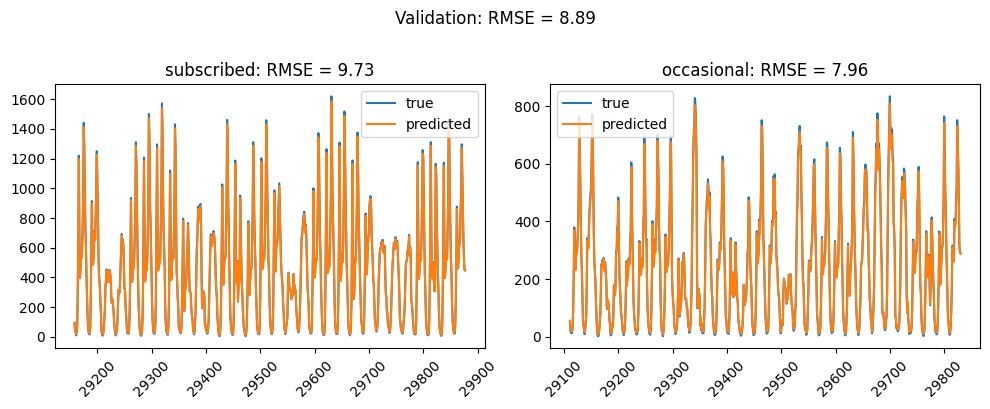

In [95]:
valid_score_s = np.sqrt(mean_squared_error(y_valid_s, y_valid_pred_s))
valid_score_o = np.sqrt(mean_squared_error(y_valid_o, y_valid_pred_o))

y_valid = pd.concat([y_valid_s, y_valid_o])
y_valid_pred = np.concatenate([y_valid_pred_s, y_valid_pred_o])
valid_score = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(y_valid_s.index, y_valid_s, label='true')
plt.plot(y_valid_s.index, y_valid_pred_s, label='predicted')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"subscribed: RMSE = {valid_score_s:.2f}")

plt.subplot(1, 2, 2)
plt.plot(y_valid_o.index, y_valid_o, label='true')
plt.plot(y_valid_o.index, y_valid_pred_o, label='predicted')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"occasional: RMSE = {valid_score_o:.2f}")

plt.suptitle(f"Validation: RMSE = {valid_score:.2f}", y=1.01)

plt.tight_layout()

## Test